In [14]:
import pandas as pd

# Carga de datasets
df_universo = pd.read_csv('../../../dataset/dataset_joined_without_cleaning/df_universo.csv', sep=',')

# Verificación rápida
print("Dataset cargado correctamente:")
print(f"universo → {df_universo.shape}")


Dataset cargado correctamente:
universo → (264921, 330)


In [15]:
df_universo['target'].value_counts() # here

target
0    232066
1     22382
5      5183
2      2112
3      1959
4      1219
Name: count, dtype: int64

In [16]:
print(f"Cantidad de variables: {len(df_universo.columns)}")

Cantidad de variables: 330


## Tratamiento de nulos

In [17]:
# Calcular cantidad y porcentaje de nulos
nulos_cantidad = df_universo.isnull().sum()
nulos_porcentaje = (df_universo.isnull().mean() * 100)

# Crear DataFrame resumen
tabla_nulos = (
    pd.DataFrame({
        'columna': nulos_cantidad.index,
        'nulos': nulos_cantidad.values,
        'porcentaje_nulos': nulos_porcentaje.values
    })
    .query("porcentaje_nulos > 0")  # ← Mostrar solo las columnas con nulos
    .sort_values(by='nulos', ascending=False)
    .reset_index(drop=True)
)

tabla_nulos


,columna,nulos,porcentaje_nulos
0,DB_SAL_CRE_2_meses_min_monto_saldo,85982,32.455713
1,DB_SAL_CRE_2_meses_sum_monto_saldo,85982,32.455713
2,DB_SAL_CRE_2_meses_prom_monto_saldo,85982,32.455713
3,DB_SAL_CRE_2_meses_max_monto_saldo,85982,32.455713
4,DB_SAL_CRE_3_meses_min_monto_saldo,84271,31.809860
...,...,...,...
106,DB_SAL_CUE_6_meses_prom_saldo_ahorros,6264,2.364478
107,DB_SAL_CUE_5_meses_prom_saldo_ahorros,6264,2.364478
108,DB_SAL_CUE_meses_caida_consecutiva,6264,2.364478
109,DB_SAL_CUE_mes_max_saldo,6264,2.364478


In [18]:
# Calcular cantidad y porcentaje de nulos
nulos_cantidad = df_universo.isnull().sum()
nulos_porcentaje = (df_universo.isnull().mean() * 100)

# Crear DataFrame resumen de nulos
tabla_nulos = (
    pd.DataFrame({
        'columna': nulos_cantidad.index,
        'nulos': nulos_cantidad.values,
        'porcentaje_nulos': nulos_porcentaje.values
    })
    .query("porcentaje_nulos > 0")  # Mostrar solo columnas con nulos
    .sort_values(by='nulos', ascending=False)
    .reset_index(drop=True)
)

# Reemplazar los nulos por la moda de cada columna (sin inplace)
for col in df_universo.columns:
    moda = df_universo[col].mode()
    if not moda.empty:
        df_universo[col] = df_universo[col].fillna(moda[0])

# Verificar si aún quedan nulos
tabla_nulos_final = (
    pd.DataFrame({
        'columna': df_universo.columns,
        'nulos': df_universo.isnull().sum().values,
        'porcentaje_nulos': (df_universo.isnull().mean() * 100).values
    })
    .query("porcentaje_nulos > 0")
)

tabla_nulos_final


,columna,nulos,porcentaje_nulos


In [19]:
df_universo['target'].value_counts()

target
0    232066
1     22382
5      5183
2      2112
3      1959
4      1219
Name: count, dtype: int64

---

## Tratamiento de outliers

In [20]:
import pandas as pd
import numpy as np

# Copia del DataFrame original
df_limpio = df_universo.copy()

# Guardar tamaño inicial
filas_antes = df_limpio.shape[0]

# Seleccionar todas las columnas numéricas excepto 'target'
cols_numericas = [col for col in df_limpio.select_dtypes(include=['number']).columns if col != 'target']

# Función para identificar outliers por Z-score
def identify_outliers_zscore(data, threshold=3):
    z_scores = np.abs((data - data.mean()) / data.std())
    return z_scores > threshold  # True donde hay outliers

# Eliminar outliers usando Z-score
for col in cols_numericas:
    mask = identify_outliers_zscore(df_limpio[col], threshold=3)
    df_limpio = df_limpio[~mask]  # Mantener solo los que NO son outliers

# Resetear índice y mostrar diferencias
df_limpio.reset_index(drop=True, inplace=True)
filas_despues = df_limpio.shape[0]

print(f"Filas antes de limpieza: {filas_antes:,}")
print(f"Filas después de limpieza: {filas_despues:,}")
print(f"Filas eliminadas: {filas_antes - filas_despues:,} ({(1 - filas_despues/filas_antes)*100:.2f}%)")


Filas antes de limpieza: 264,921
Filas después de limpieza: 85,216
Filas eliminadas: 179,705 (67.83%)


In [21]:
df_limpio['target'].value_counts()

target
0    73526
1     8733
5     1396
3      768
2      484
4      309
Name: count, dtype: int64

---

## Selección de variables

In [22]:
from scipy.stats import skew, kurtosis

# Lista de variables numéricas, excluyendo 'target'
var_num = [col for col in df_limpio.select_dtypes(include=['number']).columns if col != 'target']

Skews = []
Kurts = []

for var in var_num:
    Skews.append(skew(df_limpio[var], bias=False))       # bias=False para obtener valor ajustado
    Kurts.append(kurtosis(df_limpio[var], fisher=True, bias=False))  # fisher=True: kurtosis normalizada a 0


In [23]:
import pandas as pd

stats_df = pd.DataFrame({
    'variable': var_num,
    'skewness': Skews,
    'kurtosis': Kurts
})

stats_df


,variable,skewness,kurtosis
0,DB_CLI_edad,0.277214,-0.550805
1,DB_CLI_ingreso,0.527737,-0.119780
2,DB_CLI_anios_exp,1.066042,-0.709593
3,DB_CLI_pago_nomina,0.079298,-1.928038
4,DB_CLI_der_ingreso_por_anio_exp,-0.890153,-1.109283
...,...,...,...
312,DB_CONS_total_gasto,0.470073,-0.419574
313,DB_CONS_prop_supermercado,0.195172,-0.145102
314,DB_CONS_prop_restaurante,1.026612,0.935370
315,DB_CONS_prop_salud,0.525445,-0.292921


In [24]:
# Umbrales
skew_umbral = 1
kurt_umbral = 1

# Variables seleccionadas
vars_seleccionadas = stats_df[
    (stats_df['skewness'].abs() <= skew_umbral) &
    (stats_df['kurtosis'].abs() <= kurt_umbral)
]['variable'].tolist()

# Variables no seleccionadas
vars_no_seleccionadas = stats_df[
    (stats_df['skewness'].abs() > skew_umbral) |
    (stats_df['kurtosis'].abs() > kurt_umbral)
]['variable'].tolist()

print("Variables seleccionadas:", vars_seleccionadas)
print("Cantidad seleccionadas:", len(vars_seleccionadas))
print("\nVariables no seleccionadas:", vars_no_seleccionadas)
print("Cantidad no seleccionadas:", len(vars_no_seleccionadas))


Variables seleccionadas: ['DB_CLI_edad', 'DB_CLI_ingreso', 'DB_CLI_der_edad_ingreso_relativa', 'DB_CLI_num_productos', 'DB_CLI_relacion_ofertas_uso', 'DB_SAL_CUE_2_meses_max_saldo_ahorros', 'DB_SAL_CUE_2_meses_min_saldo_ahorros', 'DB_SAL_CUE_2_meses_sum_saldo_ahorros', 'DB_SAL_CUE_2_meses_prom_saldo_ahorros', 'DB_SAL_CUE_3_meses_max_saldo_ahorros', 'DB_SAL_CUE_3_meses_min_saldo_ahorros', 'DB_SAL_CUE_3_meses_sum_saldo_ahorros', 'DB_SAL_CUE_3_meses_prom_saldo_ahorros', 'DB_SAL_CUE_4_meses_max_saldo_ahorros', 'DB_SAL_CUE_4_meses_min_saldo_ahorros', 'DB_SAL_CUE_4_meses_sum_saldo_ahorros', 'DB_SAL_CUE_4_meses_prom_saldo_ahorros', 'DB_SAL_CUE_5_meses_max_saldo_ahorros', 'DB_SAL_CUE_5_meses_min_saldo_ahorros', 'DB_SAL_CUE_5_meses_sum_saldo_ahorros', 'DB_SAL_CUE_5_meses_prom_saldo_ahorros', 'DB_SAL_CUE_6_meses_max_saldo_ahorros', 'DB_SAL_CUE_6_meses_min_saldo_ahorros', 'DB_SAL_CUE_6_meses_sum_saldo_ahorros', 'DB_SAL_CUE_6_meses_prom_saldo_ahorros', 'DB_SAL_CUE_7_meses_max_saldo_ahorros', 'DB_S

In [25]:
# Crear el nuevo DataFrame con las variables seleccionadas, ID y target
df_filtrado_limpio = df_limpio[['ID'] + vars_seleccionadas + ['target']].copy()

# Verificar resultado
print(df_filtrado_limpio.shape)
df_filtrado_limpio.head()


(85216, 146)


,ID,DB_CLI_edad,DB_CLI_ingreso,DB_CLI_der_edad_ingreso_relativa,DB_CLI_num_productos,DB_CLI_relacion_ofertas_uso,DB_SAL_CUE_2_meses_max_saldo_ahorros,DB_SAL_CUE_2_meses_min_saldo_ahorros,DB_SAL_CUE_2_meses_sum_saldo_ahorros,DB_SAL_CUE_2_meses_prom_saldo_ahorros,...,DB_CONS_std_restaurante,DB_CONS_std_salud,DB_CONS_cv_supermercado,DB_CONS_cv_salud,DB_CONS_cv_transporte,DB_CONS_total_gasto,DB_CONS_prop_supermercado,DB_CONS_prop_salud,DB_CONS_prop_transporte,target
0,4d5a33701cb5b30b0b0a924d80de4ae78fbd0b54e2117f...,3.8498,4.6527,0.959359,1,1.0,3.1754,2.6140,5.7894,2.89470,...,1.729874,1.779892,1.707918,0.940881,1.273389,36.1042,0.204120,0.366774,0.233327,0
1,98954adf775b9fce1c9e311a025ec3e0a1c6e90f991ef7...,4.3077,4.3285,0.815513,1,1.0,3.4086,3.3238,6.7324,3.36620,...,1.355019,1.460333,0.896561,1.374333,0.487213,94.7861,0.259999,0.134523,0.282355,0
2,56fe8d95f1af9103e92ce450ece54b4647ccb001a866e6...,4.1613,4.1732,0.808556,1,1.0,3.4603,2.4541,5.9144,2.95720,...,0.583705,1.132331,0.990085,2.030880,1.216187,51.5967,0.296160,0.097254,0.187343,1
3,1feed92c9a06021c3bdb9ebbebf33202452dacd55aadd8...,3.8715,4.0801,0.837545,1,1.0,3.4285,3.2304,6.6589,3.32945,...,1.485009,0.000000,1.173752,0.000000,1.332995,18.0867,0.219946,0.000000,0.322922,0
4,fc6751ea751dad3b46cd36795b1646111ddae5f60ea58d...,4.5605,4.1369,0.743980,2,2.0,3.1701,2.8019,5.9720,2.98600,...,1.833473,0.000000,0.946081,0.000000,0.000000,26.0054,0.473448,0.000000,0.000000,0


Ejemplo de variables no seleccionadas

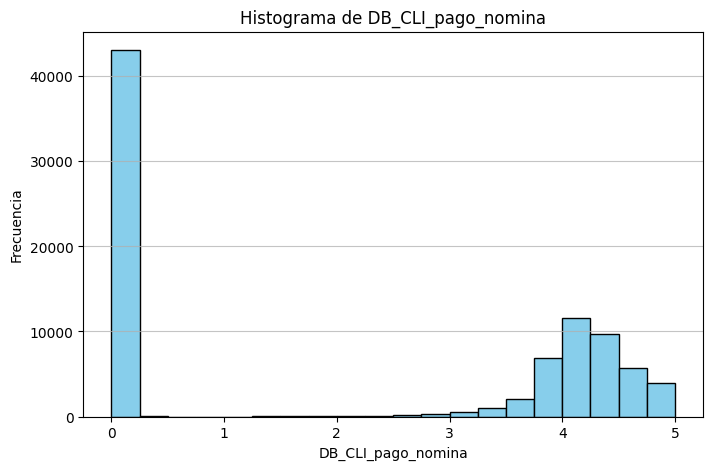

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df_limpio['DB_CLI_pago_nomina'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histograma de DB_CLI_pago_nomina')
plt.xlabel('DB_CLI_pago_nomina')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.75)
plt.show()


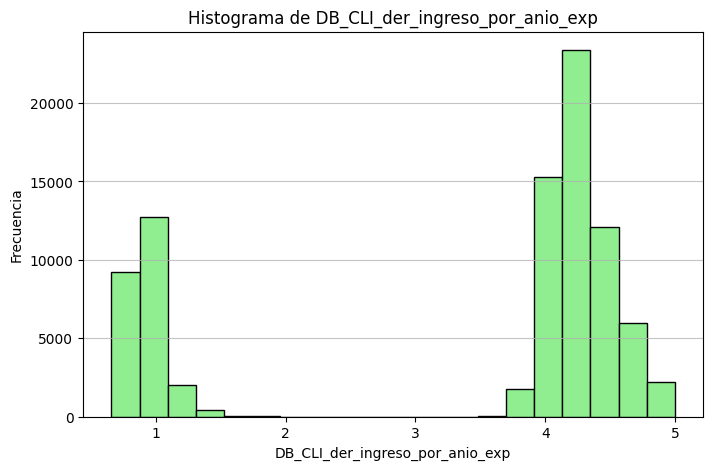

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df_limpio['DB_CLI_der_ingreso_por_anio_exp'].dropna(), 
         bins=20, color='lightgreen', edgecolor='black')
plt.title('Histograma de DB_CLI_der_ingreso_por_anio_exp')
plt.xlabel('DB_CLI_der_ingreso_por_anio_exp')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.75)
plt.show()


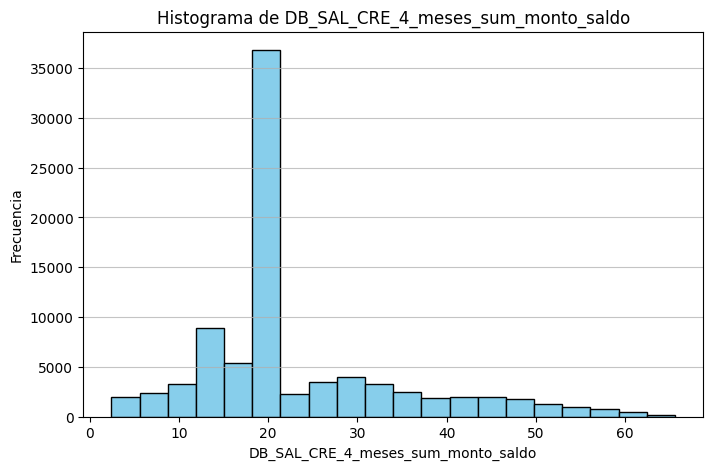

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df_limpio['DB_SAL_CRE_4_meses_sum_monto_saldo'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histograma de DB_SAL_CRE_4_meses_sum_monto_saldo')
plt.xlabel('DB_SAL_CRE_4_meses_sum_monto_saldo')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.75)
plt.show()


Ejemplo de distribución de variable seleccionada

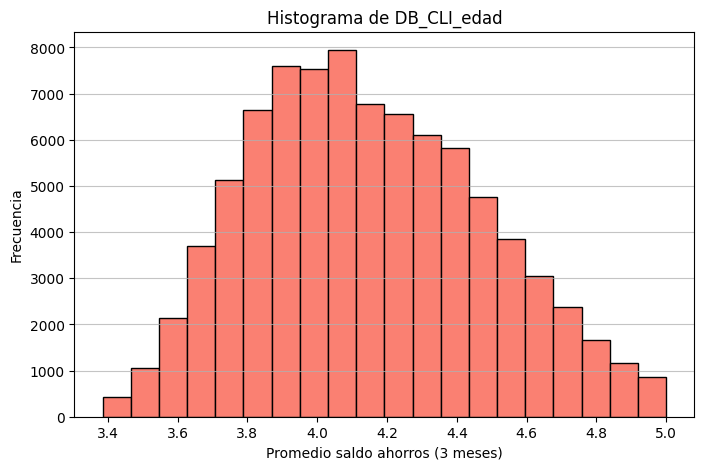

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df_limpio['DB_CLI_edad'].dropna(), 
         bins=20, color='salmon', edgecolor='black')
plt.title('Histograma de DB_CLI_edad')
plt.xlabel('Promedio saldo ahorros (3 meses)')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.75)
plt.show()


In [30]:
df_limpio['target'].value_counts()

target
0    73526
1     8733
5     1396
3      768
2      484
4      309
Name: count, dtype: int64

Agrupar por correlación

In [31]:
import pandas as pd

# === FUNCIÓN PARA AGRUPAR VARIABLES CORRELACIONADAS ===
def agrupar_por_correlacion(df, umbral=0.6):
    """
    Agrupa variables numéricas del DataFrame por correlación >= umbral.
    Retorna:
        - Una lista de sets con columnas correlacionadas.
        - Un set con columnas que no se agruparon (sin correlación suficiente).
    También imprime el progreso de cuántas columnas quedan por evaluar.
    """
    df_corr = df.corr().abs()
    columnas_restantes = set(df_corr.columns)
    grupos = []
    columnas_sin_agrupacion = set()

    while columnas_restantes:
        col = next(iter(columnas_restantes))
        
        # Buscar las columnas correlacionadas dentro de las restantes
        correladas = {c for c in columnas_restantes if df_corr.loc[col, c] >= umbral}
        
        if len(correladas) > 1:
            grupos.append(correladas)
            columnas_restantes -= correladas
            print(f"✅ Nuevo set creado ({len(correladas)} columnas): {correladas}")
            print(f"➡️  Columnas restantes: {len(columnas_restantes)}\n")
        else:
            # Guardar la columna sin agrupación
            columnas_sin_agrupacion.add(col)
            columnas_restantes.remove(col)
            print(f"⚪ Columna sin correlación suficiente: {col}")
            print(f"➡️  Columnas restantes: {len(columnas_restantes)}\n")

    return grupos, columnas_sin_agrupacion


# === APLICACIÓN DIRECTA AL DATAFRAME df_limpio ===
df_numerico = df_limpio.select_dtypes(include='number')
grupos_variables, columnas_sin_agrupacion = agrupar_por_correlacion(df_numerico, umbral=0.6)

# Mostrar resultados finales
print(f"\n🔹 Total de grupos encontrados: {len(grupos_variables)}\n")
for i, grupo in enumerate(grupos_variables, start=1):
    print(f"Set {i}, cantidad columnas: {len(grupo)}: {grupo}")

print(f"\n⚪ Total de columnas sin agrupación: {len(columnas_sin_agrupacion)}")
print(f"Columnas sin agrupación: {columnas_sin_agrupacion}")


✅ Nuevo set creado (17 columnas): {'DB_CONS_2_meses_prom_compra_restaurante', 'DB_CONS_9_meses_prom_compra_restaurante', 'DB_CONS_6_meses_min_compra_restaurante', 'DB_CONS_2_meses_min_compra_restaurante', 'DB_CONS_2_meses_max_compra_restaurante', 'DB_CONS_7_meses_prom_compra_restaurante', 'DB_CONS_2_meses_sum_compra_restaurante', 'DB_CONS_10_meses_prom_compra_restaurante', 'DB_CONS_3_meses_prom_compra_restaurante', 'DB_CONS_4_meses_min_compra_restaurante', 'DB_CONS_5_meses_prom_compra_restaurante', 'DB_CONS_3_meses_min_compra_restaurante', 'DB_CONS_4_meses_prom_compra_restaurante', 'DB_CONS_6_meses_prom_compra_restaurante', 'DB_CONS_5_meses_min_compra_restaurante', 'DB_CONS_8_meses_prom_compra_restaurante', 'DB_CONS_3_meses_sum_compra_restaurante'}
➡️  Columnas restantes: 301

✅ Nuevo set creado (27 columnas): {'DB_CONS_3_meses_prom_compra_supermercado', 'DB_CONS_7_meses_max_compra_supermercado', 'DB_CONS_2_meses_max_compra_supermercado', 'DB_CONS_4_meses_prom_compra_supermercado', 'DB

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
import pandas as pd

target = 'target'  # tu variable objetivo
X_total = df_limpio
y_total = df_limpio[target]

# === SELECCIÓN DE TOP 1 VARIABLE POR AUC DE CADA GRUPO ===
variables_seleccionadas = set()
columnas_sin_agrupacion = set()  # si no estaba definido

for i, grupo in enumerate(grupos_variables, start=1):
    if len(grupo) == 1:
        # Si el grupo tiene solo una variable, no se evalúa, se pasa a sin agrupación
        var_unica = list(grupo)[0]
        columnas_sin_agrupacion.add(var_unica)
        print(f"\n⚪ Grupo {i} tiene una sola variable: {var_unica}, se agrega a sin agrupación")
        continue

    resultados = []
    for var in grupo:
        X = X_total[[var]]
        y = y_total
        try:
            model = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=500, class_weight='balanced'))
            model.fit(X, y)
            y_pred_prob = model.predict_proba(X)
            auc = roc_auc_score(y, y_pred_prob, multi_class='ovr')
            resultados.append((var, auc))
        except Exception as e:
            # Si algo falla, dejamos la variable como sin agrupación
            columnas_sin_agrupacion.add(var)
            print(f"⚠️ Error con variable {var}: {e}. Se agrega a sin agrupación")
            continue

    if resultados:
        resultados_df = pd.DataFrame(resultados, columns=['variable','AUC']).sort_values(by='AUC', ascending=False)
        top1 = resultados_df.iloc[0]['variable']
        variables_seleccionadas.add(top1)
        print(f"\n📌 Grupo {i}: {grupo}")
        print(f"Top 1 variable por AUC: {top1}")


# === COLUMNAS SIN AGRUPACION ===
print(f"\n⚪ Columnas sin agrupación: {columnas_sin_agrupacion}")

# === VARIABLES FINALES SELECCIONADAS ===
print(f"\n✅ Cantidad {len(variables_seleccionadas)} Variables seleccionadas (top 1 de cada grupo): {variables_seleccionadas}")



📌 Grupo 1: {'DB_CONS_2_meses_prom_compra_restaurante', 'DB_CONS_9_meses_prom_compra_restaurante', 'DB_CONS_6_meses_min_compra_restaurante', 'DB_CONS_2_meses_min_compra_restaurante', 'DB_CONS_2_meses_max_compra_restaurante', 'DB_CONS_7_meses_prom_compra_restaurante', 'DB_CONS_2_meses_sum_compra_restaurante', 'DB_CONS_10_meses_prom_compra_restaurante', 'DB_CONS_3_meses_prom_compra_restaurante', 'DB_CONS_4_meses_min_compra_restaurante', 'DB_CONS_5_meses_prom_compra_restaurante', 'DB_CONS_3_meses_min_compra_restaurante', 'DB_CONS_4_meses_prom_compra_restaurante', 'DB_CONS_6_meses_prom_compra_restaurante', 'DB_CONS_5_meses_min_compra_restaurante', 'DB_CONS_8_meses_prom_compra_restaurante', 'DB_CONS_3_meses_sum_compra_restaurante'}
Top 1 variable por AUC: DB_CONS_2_meses_max_compra_restaurante

📌 Grupo 2: {'DB_CONS_3_meses_prom_compra_supermercado', 'DB_CONS_7_meses_max_compra_supermercado', 'DB_CONS_2_meses_max_compra_supermercado', 'DB_CONS_4_meses_prom_compra_supermercado', 'DB_CONS_10_m

In [33]:
df_limpio['target'].value_counts()

target
0    73526
1     8733
5     1396
3      768
2      484
4      309
Name: count, dtype: int64

In [34]:
variables_seleccionadas

{'DB_CLI_der_edad_laboral_relativa',
 'DB_CLI_edad',
 'DB_CLI_num_ofertas',
 'DB_CLI_num_productos',
 'DB_CLI_pago_nomina',
 'DB_CONS_11_meses_max_compra_transporte',
 'DB_CONS_11_meses_prom_compra_restaurante',
 'DB_CONS_12_meses_max_compra_restaurante',
 'DB_CONS_12_meses_max_compra_salud',
 'DB_CONS_12_meses_max_compra_supermercado',
 'DB_CONS_2_meses_max_compra_restaurante',
 'DB_CONS_2_meses_sum_compra_salud',
 'DB_CONS_2_meses_sum_compra_transporte',
 'DB_CONS_3_meses_min_compra_salud',
 'DB_CONS_3_meses_min_compra_supermercado',
 'DB_CONS_5_meses_min_compra_transporte',
 'DB_CONS_6_meses_min_compra_supermercado',
 'DB_CONS_7_meses_max_compra_supermercado',
 'DB_CONS_8_meses_max_compra_restaurante',
 'DB_CONS_8_meses_max_compra_supermercado',
 'DB_CONS_8_meses_min_compra_supermercado',
 'DB_CONS_8_meses_min_compra_transporte',
 'DB_CONS_total_gasto',
 'DB_SAL_CRE_2_meses_prom_monto_saldo',
 'DB_SAL_CRE_3_meses_sum_monto_saldo',
 'DB_SAL_CRE_max_dias_atraso',
 'DB_SAL_CRE_std_mont

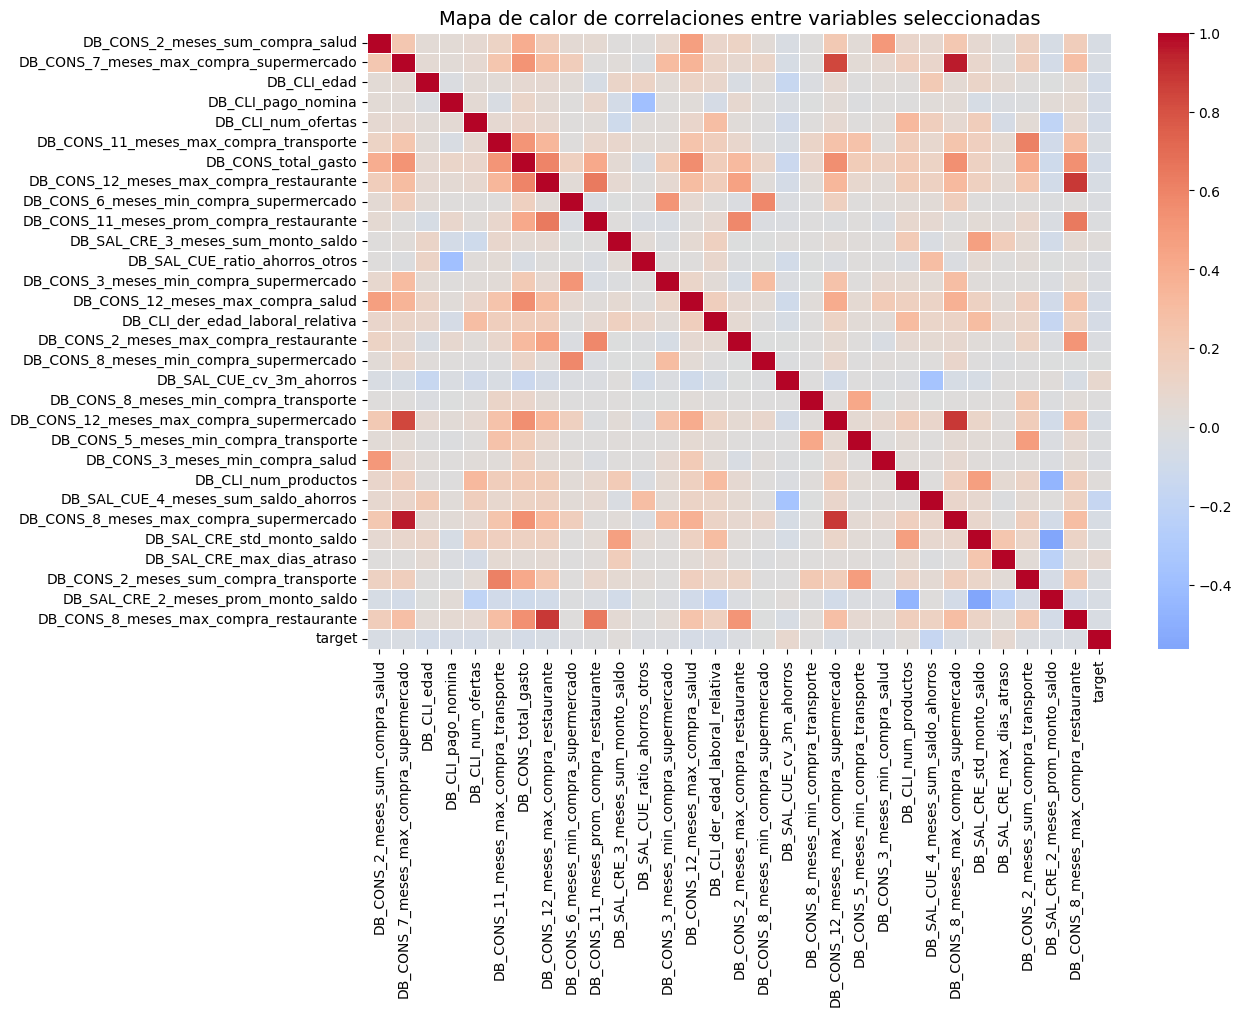

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que tienes tu DataFrame principal
# df_limpio = ...  # DataFrame con todas las variables

# Lista de variables seleccionadas
features = list(variables_seleccionadas) + ['target']  # Asegúrate de incluir 'target' si es necesario

# Subconjunto del DataFrame solo con esas variables
df_subset = df_limpio[features]

# Calcular la matriz de correlación
corr_matrix = df_subset.corr()

# Configurar el tamaño del gráfico
plt.figure(figsize=(12, 8))

# Dibujar el heatmap
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    annot=False,   # pon True si quieres mostrar los valores
    center=0,
    linewidths=0.5
)

plt.title("Mapa de calor de correlaciones entre variables seleccionadas", fontsize=14)
plt.show()


---

In [37]:
df_save = df_limpio[features]
import os
os.makedirs(r'../../../dataset/cleaned_final_for_training', exist_ok=True)
df_save.to_csv(r'../../../dataset/cleaned_final_for_training/df_final.csv', index=False, encoding='utf-8')
print("✅ Archivo 'df_limpio.csv' guardado correctamente en '../../../dataset/cleaned_final_for_training/'")

✅ Archivo 'df_limpio.csv' guardado correctamente en '../../../dataset/cleaned_final_for_training/'
